==============================================================================================
# Practicum 5

==============================================================================================

## Delivery

Your overall grading will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented exhaustively and in **English**. 

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Answers to questions also need to be in **English**.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- The deliverable of both parts must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook (upload the ones that were not provided)
    
- It is required that your code can be run by us without need of any modification and without getting any errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please refrain from utilizing resources like ChatGPT to complete this lab assignment.


**Deadline: December 22th, 23:00 h**

==============================================================================================

This lab covers the following topics: 
* Gaussian filters
* Descriptors based on texture
* Distance between images and similarity search
* Face detection using:
    * Haar-like features
    * Adaboost
    * PCA



==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



### Imports

In [39]:
%matplotlib inline
# GENERAL ONES FOR IMAGE ANALYSIS
import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io, img_as_float
from skimage.color import rgb2gray, rgba2rgb
from skimage.exposure import histogram
from skimage.transform import resize
from scipy import ndimage
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import time
### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

# Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images/filter_bank.png">


We import Leung-Malik filters as follows:

In [40]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()
# NOTE: If this does not work, go to appendix for function code

### Plotting all filters

Plot the created filters as images similar to the figure above.

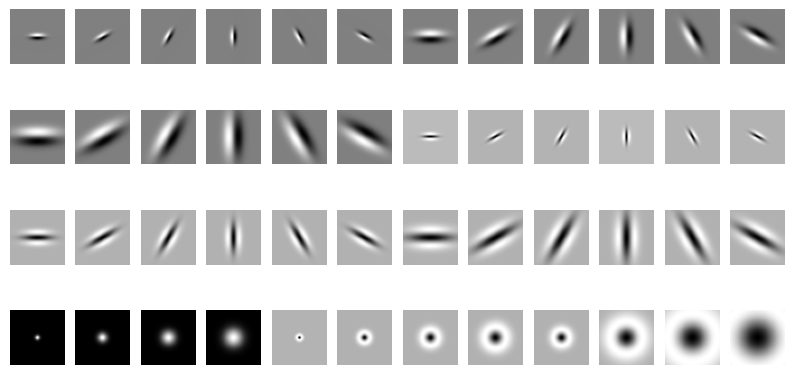

In [41]:
n_filters = filter_bank.shape[-1]


plt.figure(figsize=(10, 5))

for k in range(n_filters):
    plt.subplot(4, 12, k + 1)
    plt.imshow(filter_bank[:, :, k], cmap='gray')
    plt.axis("off")

plt.show()

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

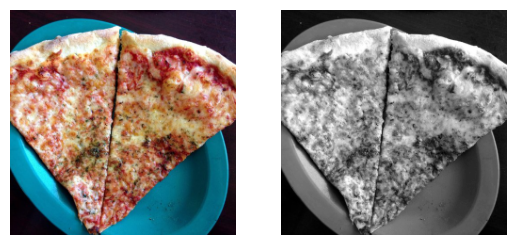

In [42]:
def plot_gray_rgb(image, shape):

    image_resize = resize(image, shape, anti_aliasing=True)
    grayscale = rgb2gray(image_resize)

    plt.subplot(1,2,1)
    plt.imshow(image_resize)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')

    plt.show()

    return grayscale

image = io.imread('images/pizza.jpg')
shape = (240, 240)
pizza_gray = plot_gray_rgb(image, shape)


**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the **mean of the absolute value of the convolved image** by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [43]:
def get_image_features(image, filter_bank, n_filters):
    feature_vector = np.zeros(n_filters)

    for filter_pos in range(n_filters):
        mask_filter = filter_bank[:,:,filter_pos]
        convolved_image = ndimage.convolve(image, mask_filter, mode='constant')
        feature_vector[filter_pos] = np.mean(abs(convolved_image))

    return feature_vector

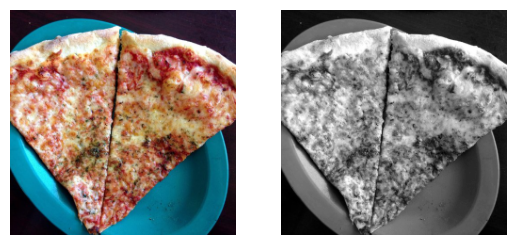

array([0.01647802, 0.01525403, 0.01522918, 0.01680061, 0.01815106])

In [44]:
## Try the function
image = io.imread('images/pizza.jpg')
pizza_gray = plot_gray_rgb(image, (240, 240))
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
im_features


**1.3** (Optional) Try ``get_image_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


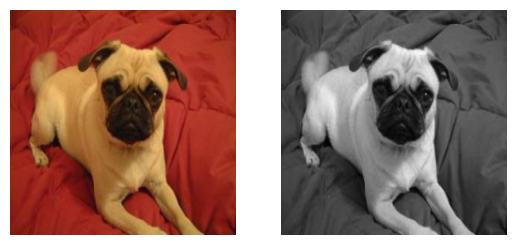

array([0.00777532, 0.0078269 , 0.00882166, 0.00983738, 0.00984861])

In [45]:
dog_image = io.imread('images/dog.jpg')
dog_gray = plot_gray_rgb(dog_image, (240, 240))
n_filters = 5
im_features_dog = get_image_features(dog_gray, filter_bank, n_filters)
im_features_dog

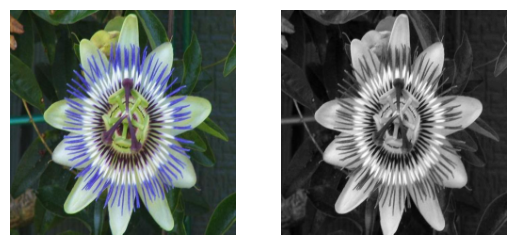

array([0.0119757 , 0.01292875, 0.01454731, 0.01509882, 0.01398316])

In [46]:
flower_image = io.imread('images/flower.jpg')
flower_gray = plot_gray_rgb(flower_image, (240, 240))
n_filters = 5
im_features_flowers = get_image_features(flower_gray, filter_bank, n_filters)
im_features_flowers

### Visualizing features

**1.4** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that receives the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [47]:
def visualize_features(im, filter_bank, n_filters=5):
    plt.figure(figsize=(15, n_filters * 2))

    for filter_pos in range(n_filters):
        mask_filter = filter_bank[:, :, filter_pos]
        convolved_image = ndimage.convolve(im, mask_filter, mode='constant', cval=0.0)

        # Display convolved image in the first row
        plt.subplot(2, n_filters, filter_pos + 1)
        plt.imshow(np.abs(convolved_image), cmap='gray')
        plt.axis('off')

        # Display individual filter in the second row
        plt.subplot(2, n_filters, n_filters + filter_pos + 1)
        plt.imshow(mask_filter, cmap='gray')
        plt.axis('off')

    plt.show()

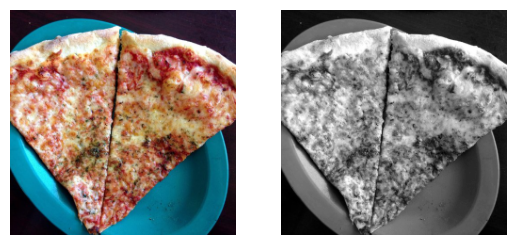

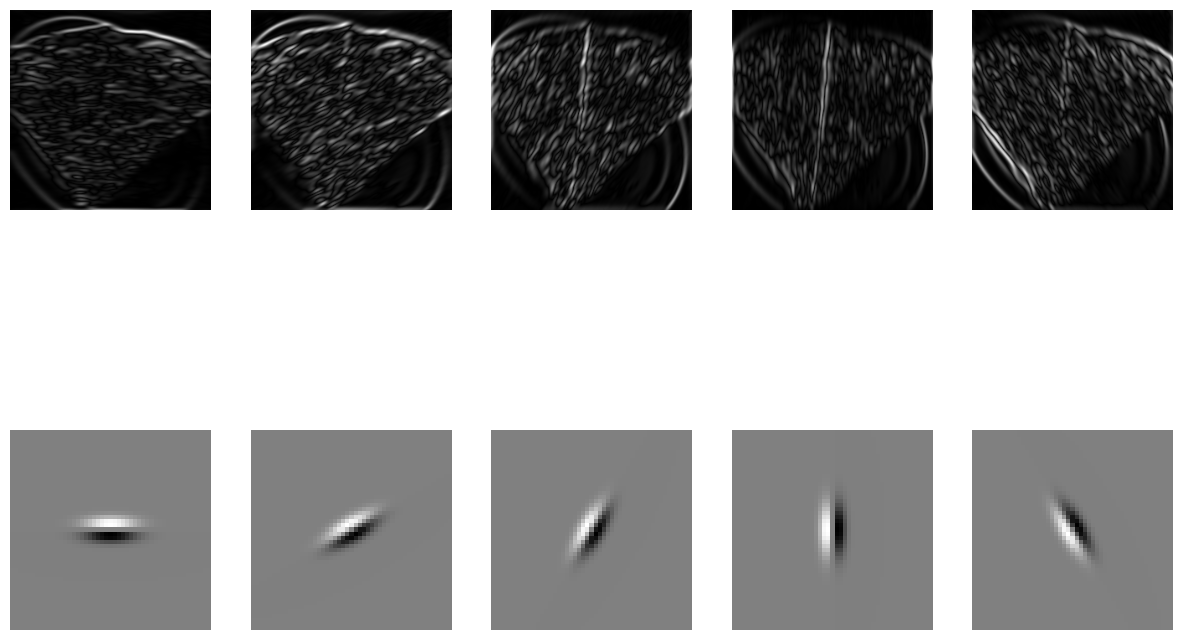

In [48]:
image = io.imread('images/pizza.jpg')
pizza_gray = plot_gray_rgb(image, (240, 240))
## Try the function
visualize_features(pizza_gray, filter_bank)

**1.5** (Optional) Try ``visualize_features()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

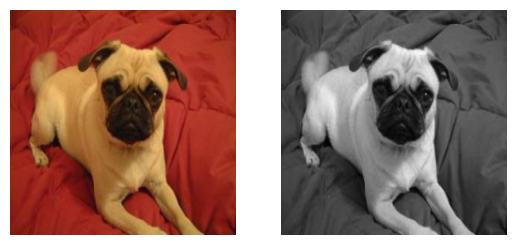

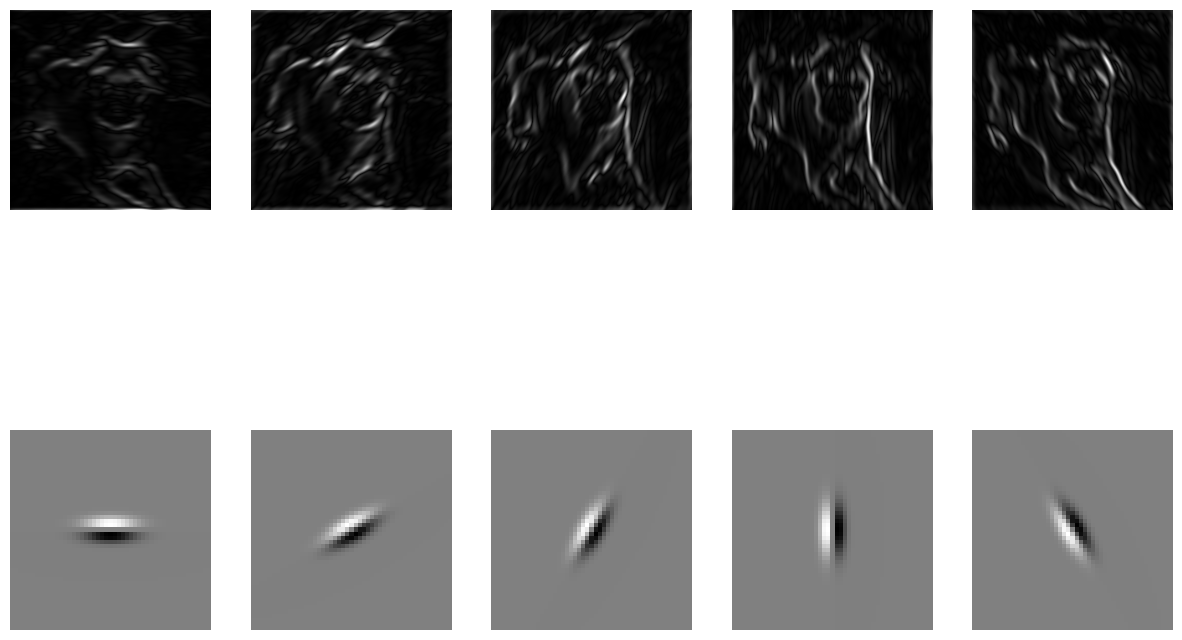

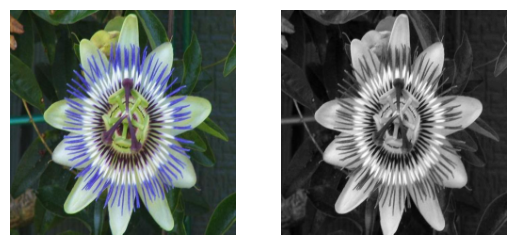

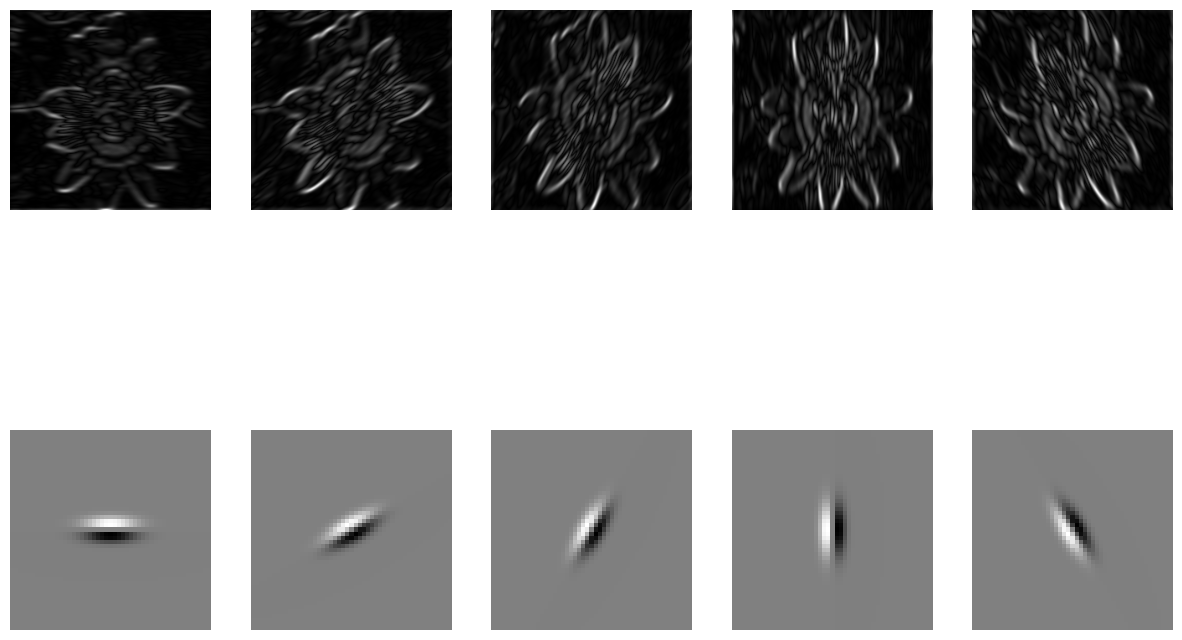

In [49]:
dog_image = io.imread('images/dog.jpg')
dog_gray = plot_gray_rgb(dog_image, (240, 240))
visualize_features(dog_gray, filter_bank)

flower_image = io.imread('images/flower.jpg')
flower_gray = plot_gray_rgb(flower_image, (240, 240))
visualize_features(flower_gray, filter_bank)

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [50]:
def read_images(images_path, shape=(240, 240)):
    image_array = []
    for filename in os.listdir(images_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Read the image
            image_path = os.path.join(images_path, filename)
            image = io.imread(image_path)

            # Resize the image
            resized_image = resize(image, shape, anti_aliasing=True)

            # Append the resized image to the array
            image_array.append(resized_image)

    return np.array(image_array)

pizza_images = read_images('./images/pizza/')
flowers_images = read_images('./images/flowers/')
pets_images = read_images('./images/pets/')

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

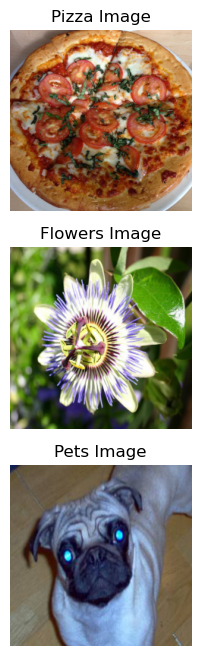

In [51]:
# Visualize one image from each category
plt.figure(figsize=(8, 8))

# Visualize pizza image
plt.subplot(3, 1, 1)
plt.imshow(pizza_images[0])
plt.title('Pizza Image')
plt.axis('off')

# Visualize flowers image
plt.subplot(3, 1, 2)
plt.imshow(flowers_images[0])
plt.title('Flowers Image')
plt.axis('off')

# Visualize pets image
plt.subplot(3, 1, 3)
plt.imshow(pets_images[0])
plt.title('Pets Image')
plt.axis('off')

plt.show()

How many images there are in **each** directory?

In [52]:
print("Pizza Images: ", len(pizza_images))
print("Flowers Images: ", len(flowers_images))
print("Pet Images: ", len(pets_images))

Pizza Images:  30
Flowers Images:  29
Pet Images:  29


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `get_image_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [53]:
def get_dataset_features(all_images, filter_bank, n_filters=6):
    n_images = len(all_images)
    all_feature_vector = np.zeros((n_images,n_filters))

    for image in range(n_images):
        imagegray = rgb2gray(all_images[image])
        all_feature_vector[image] = get_image_features(imagegray, filter_bank, n_filters)

    return all_feature_vector

In [54]:
## Try the function
all_images = np.vstack((pizza_images, flowers_images, pets_images))
feature_vectors=get_dataset_features(all_images,  filter_bank)
feature_vectors

array([[0.01934308, 0.01872175, 0.0171153 , 0.01560672, 0.01649987,
        0.01802183],
       [0.01248335, 0.01371751, 0.01426132, 0.01390049, 0.0138331 ,
        0.01309755],
       [0.02348971, 0.02196051, 0.01876477, 0.01773991, 0.02080202,
        0.02346386],
       [0.01636645, 0.01522763, 0.01286115, 0.01123859, 0.01222709,
        0.01531624],
       [0.01522587, 0.01345767, 0.0117895 , 0.01125129, 0.01291045,
        0.01523241],
       [0.01647802, 0.01525403, 0.01522918, 0.01680061, 0.01815106,
        0.01820259],
       [0.01634201, 0.01632064, 0.01440042, 0.01279171, 0.01439599,
        0.0162817 ],
       [0.02448165, 0.02116042, 0.01657176, 0.01576209, 0.01934632,
        0.02384159],
       [0.01062811, 0.01097185, 0.01141578, 0.01188912, 0.01179685,
        0.01124034],
       [0.02087817, 0.01922914, 0.01759604, 0.01786586, 0.01771414,
        0.01958984],
       [0.02288712, 0.02095865, 0.01998135, 0.02087751, 0.02201522,
        0.023296  ],
       [0.0160703 , 0

Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[2]*), image #33, and image #53, directly from the vector

In [55]:
print("Features for image #3: ")
print(feature_vectors[2])

print("Features for image #33: ")
print(feature_vectors[32])

print("Features for image #53: ")
print(feature_vectors[52])

Features for image #3: 
[0.02348971 0.02196051 0.01876477 0.01773991 0.02080202 0.02346386]
Features for image #33: 
[0.02001188 0.01820625 0.01597421 0.01386115 0.01503769 0.01847237]
Features for image #53: 
[0.00849561 0.00922798 0.01047286 0.01106003 0.01040573 0.00940927]


### Visualizing the features of an image

**2.3** Define a function `visualize_features_imgs(im_index, feature_vector)` that given n different images, plots their features. Use different colors to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

<img src="./images/example_plot_features.jpg" >


In [56]:
def visualize_features_imgs(im_index, feature_vector):
    plt.figure(figsize=(12, 6))

    for i, im_index in enumerate(im_index):
        features = feature_vector[im_index]
        plt.plot(range(1, len(features) + 1), features, label=f"Image {im_index + 1}", marker='o')

    plt.title("Visualization of Features")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

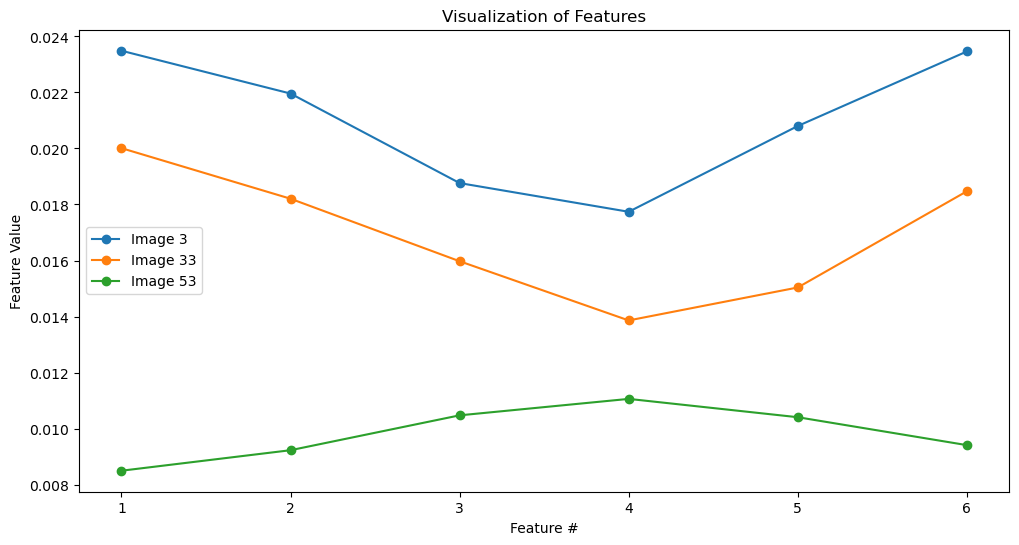

In [57]:
## Try the function
visualize_features_imgs([2,32,52] , feature_vectors)


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

In [58]:
def compute_distance(im_features, feature_vectors):
    distances = np.linalg.norm(im_features - feature_vectors, axis=1)
    return distances

def retrieve_images(im_features, feature_vectors, k=5):
    distances = compute_distance(im_features, feature_vectors)
    closest_images = np.argsort(distances)[:k]

    closest_distances = distances[closest_images]

    return closest_distances, closest_images


Try your function using ``/images/pizza.jpg``.

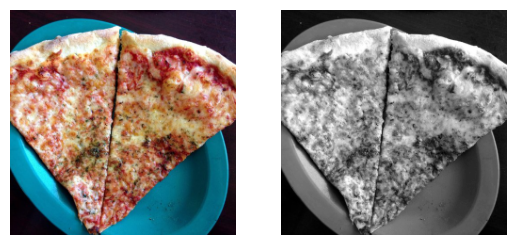

[ 5 85 86 35 87] [0.         0.00201855 0.00208721 0.00226314 0.00274837]


In [59]:
#Pizza.jpg
image = io.imread('images/pizza.jpg')
pizza_gray = plot_gray_rgb(image, (240, 240))
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)

#We need to do the feature vectors but with n_filters = 5
all_images = np.vstack((pizza_images, flowers_images, pets_images))
feature_vectors=get_dataset_features(all_images,  filter_bank, n_filters=5)

# Try your function
distances, closest = retrieve_images(im_features, feature_vectors)
print(closest, distances)

**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


In [60]:
def show_closest_images(all_images, closest, distances):
    # Visualize the closest images
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(closest):
        plt.subplot(1, len(closest), i + 1)
        plt.imshow(all_images[index])
        plt.title(distances[i])
        plt.axis("off")
    plt.show()

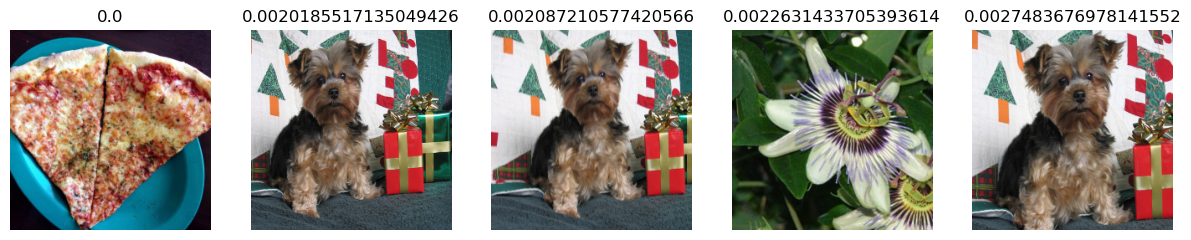

In [61]:
show_closest_images(all_images, closest, distances)

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [62]:
def accuracy(feature_vectors, class_labels, im_features, class_im, k=5):
    distances = compute_distance(im_features, feature_vectors)
    closest_indices = np.argsort(distances)[1:k+1]  # Exclude the query image itself

    # Count the number of retrieved images belonging to class_im
    correct_count = np.sum(class_labels[closest_indices] == class_im)

    # Calculate accuracy
    accuracy = correct_count / k
    return accuracy

In [63]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
#We need to do the feature vectors but with n_filters = 5
all_images = np.vstack((pizza_images, flowers_images, pets_images))
feature_vectors=get_dataset_features(all_images,  filter_bank, n_filters=5)

print("acc k=5:", accuracy(feature_vectors, class_labels, im_features, 0))

print("acc k=10:", accuracy(feature_vectors, class_labels, im_features, 0, k=10))

acc k=5: 0.0
acc k=10: 0.2


Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

RESPUESTA

### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

* Plot the new features of an image, using `visualize_features_imgs()`. 
* Then, show the 5 closest images (use show_closest_images) from `im_features`
* Compute the accuracy. 

**Is there any difference? Do we obtain the same images than previously?**

In [64]:
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
#We need to do the feature vectors but with n_filters = 5
all_images = np.vstack((pizza_images, flowers_images, pets_images))
feature_vectors=get_dataset_features(all_images,  filter_bank, n_filters=5)

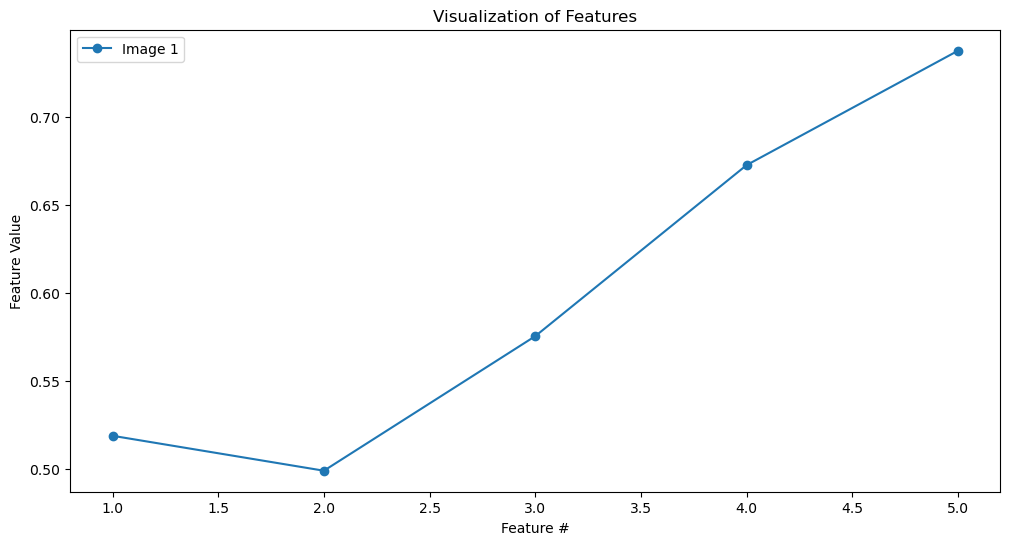

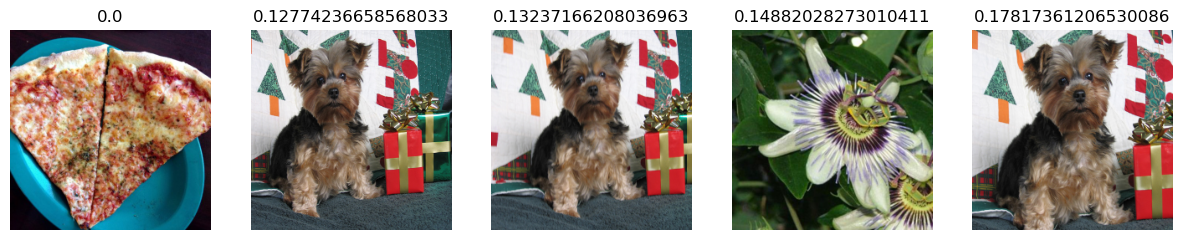

Accuracy with k=5:  0.0
Accuracy with k=10:  0.1


In [65]:
def min_max_normalize(features, min_vals, max_vals):
    normalized_features = (features - min_vals) / (max_vals - min_vals)
    return normalized_features

# Assuming feature_vectors, im_features are defined
min_vals = np.min(feature_vectors, axis=0)
max_vals = np.max(feature_vectors, axis=0)

normalized_feature_vectors = min_max_normalize(feature_vectors, min_vals, max_vals)
#Reshape for do 2D features
im_features_2d = im_features.reshape(1, -1)
normalized_im_features = min_max_normalize(im_features_2d, min_vals, max_vals)

# Plot the new features of an image
visualize_features_imgs([0], normalized_im_features)

# Show the 5 closest images
distances, closest = retrieve_images(normalized_im_features, normalized_feature_vectors, k=5)
show_closest_images(all_images, closest, distances)

# Compute the accuracy
acc = accuracy(normalized_feature_vectors, class_labels, normalized_im_features, 0, k=5)
print("Accuracy with k=5: ", acc)

acc10 = accuracy(normalized_feature_vectors, class_labels, normalized_im_features, 0, k=10)
print("Accuracy with k=10: ", acc10)

# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, similar to what it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** Consider each bin from each channel as a feature, create a vector with all the features together. 

In [66]:
def lm_features_rgb(rgb_image, n_bins=12):
    if rgb_image.dtype == 'uint8':
        rgb_image = img_as_float(rgb_image)

    # Initialize an empty feature vector
    features_vector = []
    # Compute histograms for each channel (L, a, b)
    for channel in range(rgb_image.shape[2]):
        features, _ = histogram(rgb_image[:, :, channel], nbins=n_bins)

        features_vector.append(features)

    features_vec = np.concatenate(features_vector)


    return np.array(features_vec)

In [67]:
# Try your function
pizza_rgb = io.imread('images/pizza.jpg')
lm_rgb_features = lm_features_rgb(pizza_rgb, n_bins=12)
print(len(lm_rgb_features))
lm_rgb_features

36


array([68557, 24657, 11114,  2716,  4752,  7379, 12491, 21764, 33102,
       30966, 24778, 19868, 32165, 25035, 14470, 16588, 27551, 38301,
       36364, 22265, 17489, 13104,  9434,  9378, 23817, 31035, 36090,
       25950, 26124, 25775, 28016, 22826, 19022,  8970,  6534,  7985],
      dtype=int64)



































































































































## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in  `all_images` and save them in `lm_dataset_features`.

In [68]:
%%time 
'''
Solution
'''

def lm_features_all_rgb(rgb_images, n_bins=12):

    # Initialize an empty array to store features for all datapoints
    lm_dataset_features = []

    # Compute features for each image in 'all_images'
    for image in rgb_images:
        features_rgb = lm_features_rgb(image, n_bins=n_bins)

    lm_dataset_features = np.array(features_rgb)

    return lm_dataset_features

lm_dataset_features = lm_features_all_rgb(all_images)
print(len(lm_dataset_features))
lm_dataset_features

36
CPU times: total: 188 ms
Wall time: 216 ms


array([2897, 3247, 4761, 5576, 5062, 5841, 4960, 4160, 3248, 4371, 4162,
       9315, 2814, 7361, 5180, 6875, 6287, 5980, 4928, 2865, 1687, 1441,
       3463, 8719, 2992, 7227, 9506, 7879, 6460, 4698, 2669, 1554, 1092,
       1252, 2769, 9502], dtype=int64)


## Compute the accuracy of the method using `lm_features_rgb`

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Show the 4 closest images to the query images in the `lm_rgb` space with the function built before.

Is the accuracy higher? Please, comment the results.

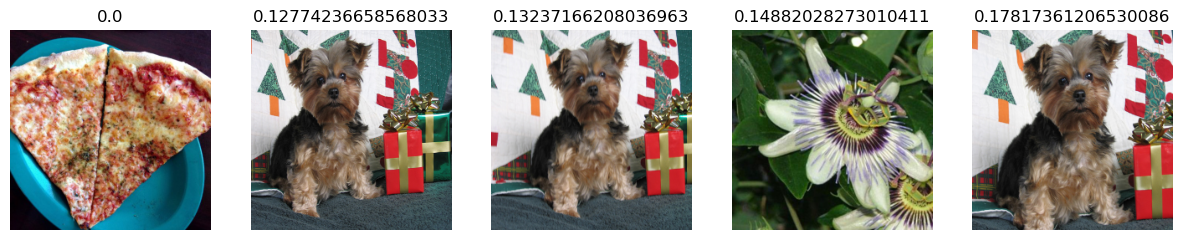

NameError: name 'class_im' is not defined

In [70]:
# Your solution here
retrieve_images(im_features, feature_vectors)
show_closest_images(all_images, closest, distances)
accuracy(feature_vectors, class_labels, im_features, class_im)



==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features.

### 6. Building integral image and Haar-like features

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="images/integral_image.PNG" width=250, height=2500>

An example :

<img src="images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

# Your written answer here

**6.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one. Refrain from using built-in functions that already do the integral, compute it yourself. 

In [71]:
def to_integral_image(random_img, tolerance=1e-15):
    row_sum = np.zeros(random_img.shape)
    integral_image = np.zeros((random_img.shape[0] + 1, random_img.shape[1] + 1))

    for j in range(random_img.shape[1]):
        for i in range(random_img.shape[0]):
            row_sum[i, j] = row_sum[i - 1, j] + random_img[i, j]
            integral_image[i + 1, j + 1] = integral_image[i + 1, j] + row_sum[i, j]

    # Apply tolerance for better calculations
    integral_image = np.where(np.abs(integral_image) < tolerance, 0, integral_image)

    return integral_image


In [72]:
# Visualizing results on a random grayscale image
random_img = np.random.rand(5,5)
#We need the tolerance for the correct calculation
integral_img = to_integral_image(random_img)

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

(5, 5)


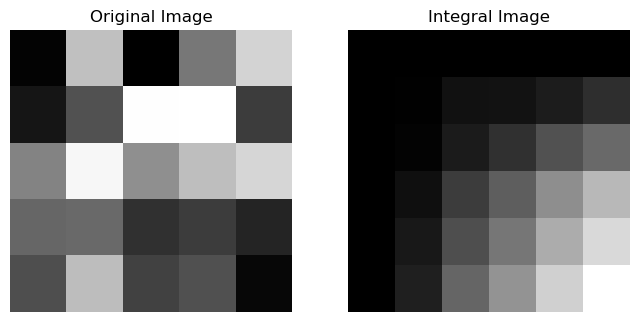

In [73]:
# Test 1
assert np.allclose(random_img.sum() , integral_img[-1, -1]), f"Test 1 failed: {random_img.sum()} != {integral_img[-1, -1]}"

# Test 2
test_sum_row = random_img[0, :].sum()
assert test_sum_row == integral_img[1, -1], f"Test 2 failed: {test_sum_row} != {integral_img[1, -1]}"
print(random_img.shape)
# Visualize the original and integral images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(random_img, cmap='gray', interpolation='nearest')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(integral_img, cmap='gray', interpolation='nearest')
plt.title('Integral Image')
plt.axis('off')

plt.show()

**6.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

Here is an example (you don't have to pick this image, you can do it at random):
<img src="images/integral_image_example.jpg" width=500, height=250>

La imatge es:  24


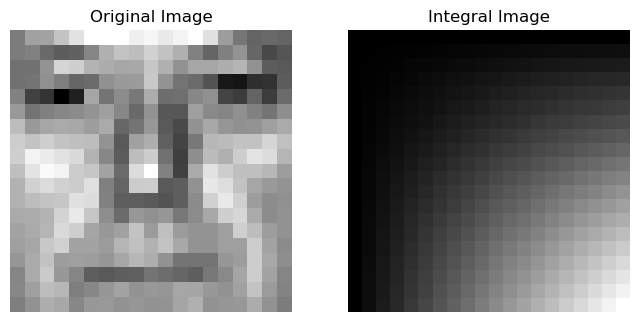

In [74]:
def read_faces(images_path):
    image_array = []
    for filename in os.listdir(images_path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Read the image
            image_path = os.path.join(images_path, filename)
            image = io.imread(image_path)


            # Append the original image to the array
            image_array.append(image)

    return np.array(image_array)

faces_array = read_faces('./images/faces/')

def array_to_integral(array):
    integral_array = []
    for image in array:
        integral_array.append(to_integral_image(image, tolerance=1e-15))

    return integral_array

integral_faces = array_to_integral(faces_array)
random = np.random.random_integers(0, 39)

print("La imatge es: ", random)


# Visualize the original and integral images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(faces_array[random], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(integral_faces[random], cmap='gray')
plt.title('Integral Image')
plt.axis('off')

plt.show()

**6.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage (no need to provide a written answer here, just make sure you are obtain same results).

True


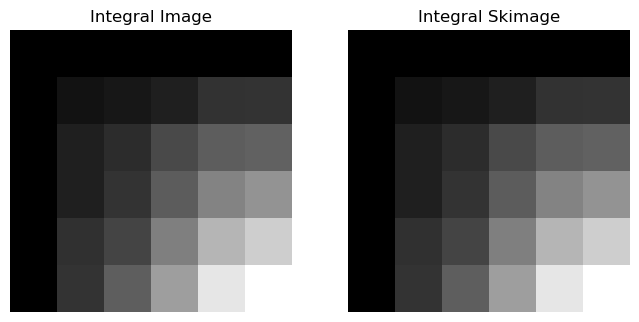

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.8193776   1.0235382   1.35624937  2.19514867  2.20828435]
 [ 0.          1.36122283  1.96964063  3.18954773  4.02926887  4.26858764]
 [ 0.          1.37414481  2.23253599  4.01966769  5.69925986  6.3976714 ]
 [ 0.          2.10140439  2.96839206  5.52873743  7.84537287  8.93365032]
 [ 0.          2.24548515  4.07429183  6.8392546   9.98425954 11.07737923]]
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.8193776   1.0235382   1.35624937  2.19514867  2.20828435]
 [ 0.          1.36122283  1.96964063  3.18954773  4.02926887  4.26858764]
 [ 0.          1.37414481  2.23253599  4.01966769  5.69925986  6.3976714 ]
 [ 0.          2.10140439  2.96839206  5.52873743  7.84537287  8.93365032]
 [ 0.          2.24548515  4.07429183  6.8392546   9.98425954 11.07737923]]


In [75]:
# Assuming random_img is your 2D array
random_img = np.random.rand(5, 5)

# Your implementation
integral_image_custom = to_integral_image(random_img)

# Add a row and a column of zeros to match the shape of the custom implementation
integral_image_skimage = np.zeros((random_img.shape[0] + 1, random_img.shape[1] + 1))
integral_image_skimage[1:, 1:] = integral_image(random_img)

# Compare results numerically
print(np.allclose(integral_image_custom, integral_image_skimage))

# Visualize the original and integral images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(integral_image_custom, cmap='gray')
plt.title('Integral Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(integral_image_skimage, cmap='gray')
plt.title('Integral Skimage')
plt.axis('off')

plt.show()

print(integral_image_custom)
print(integral_image_skimage)

## Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**6.4** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [76]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [81]:
def extract_feature_image(image, feature_type, feature_coord=None):
    pass



# Get the feature vector
feature_vector = extract_feature_image(faces_array, feature_types)
feature_vector
print(feature_vector.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

**6.5** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="images/image1.png" width=600, height=300>

*Note that there are multiple features and therefore your results might not exactly match this example, depending on your selection.*

In [79]:
#your solution

## 7 Face detection using an Adaboost

**7.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features (use the `built extract_feature_image` for this). 

Futhermore, build the class labels vector ``y`` with the label of all the images. Make sure both, images and labels are numpy array objects.

In [80]:
faces_images = read_images('./images/faces/')
nonfaces_images = read_images('./images/nonfaces/')

**7.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Print the size of your images train and test set. 

**7.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

In [ ]:
# Your solution here

**7.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. Make sure to use your test set for this. What are these methods doing?

In [ ]:
# Your solution here

Change the parameter ``n_estimators`` and see what happens to the test set accuracy. Does the performance increased or decreased?

Try at least 3 different values of `n_estimators`

In [ ]:
# Your solution here

**7.5 (Optional)** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features of the model. 

In [ ]:
# Your solution here

==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 8. Load and prepare data for PCA

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**8.1** Load the dataset, obtaining only those cases where there are, **at least, 100 images**. Check the final number of images, image shapes and labels of the images.

*Hint: There is a parameter to set the minimum number of faces per person to load in the dataset function*

Total dataset size:
n_samples: 1140
n_features: 2914
n_classes: 5
Image size: 62x47
Class names: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


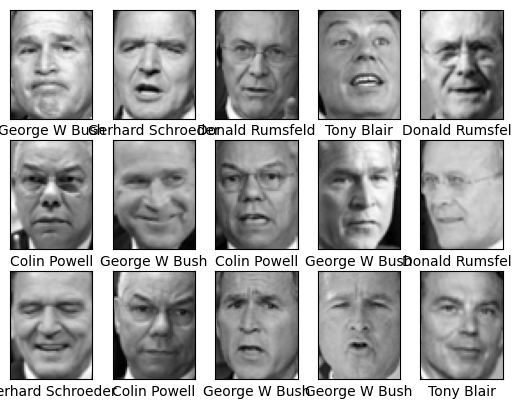

In [82]:
from sklearn.datasets import fetch_lfw_people

# Load the dataset with the constraint of a minimum of 100 images per person
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.5, color=False,
                              slice_=(slice(70, 195, None), slice(78, 172, None)),
                              download_if_missing=True)

# The number of samples and features can be found in the data's shape
n_samples, h, w = lfw_people.images.shape
n_features = lfw_people.data.shape[1]

# The label to predict is the id of the person
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Print details about the dataset
print(f"Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")
print(f"Image size: {h}x{w}")
print(f"Class names: {target_names}")  # This prints all the class names

# Check a few samples to ensure loading is correct (optional)
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(lfw_people.images[i], cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=target_names[lfw_people.target[i]])
plt.show()

**8.2** Plot an image frome each example, with its name as the title of the image.

<img src="images/example.png" width=500, height=500>

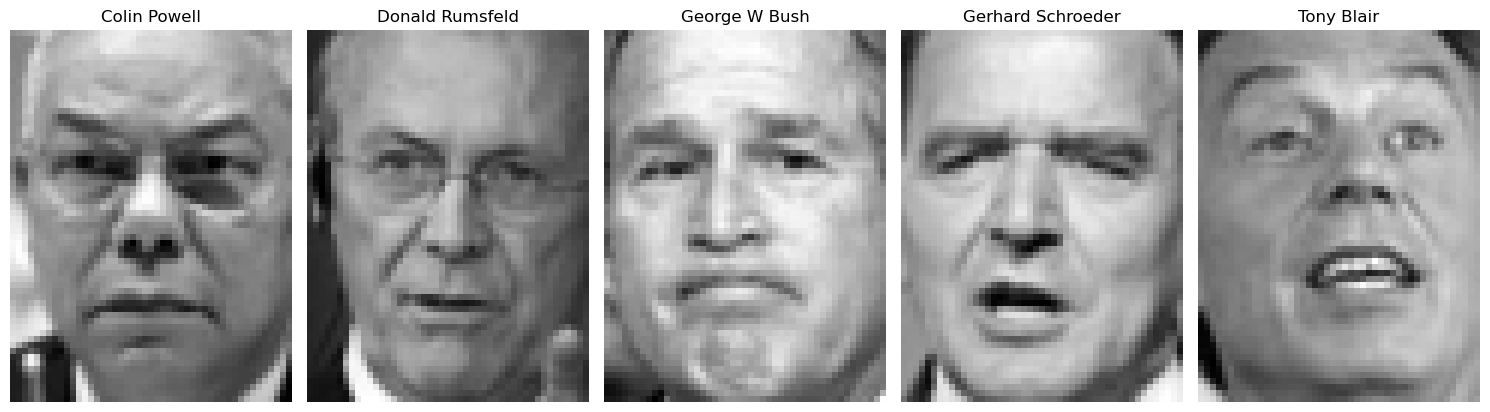

In [83]:
# Get unique labels (person names)
unique_targets = np.unique(lfw_people.target)
n_unique_targets = unique_targets.shape[0]

# Plot an image for each unique person
fig, ax = plt.subplots(1, n_unique_targets, figsize=(15, 5))

for i, target in enumerate(unique_targets):
    # Find the first instance of this person
    image_index = np.where(lfw_people.target == target)[0][0]
    image = lfw_people.images[image_index]
    
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(lfw_people.target_names[target])
    ax[i].axis('off')

plt.tight_layout()
plt.show()

**8.3** Divide the dataset into train and test set (0.7/0.3). Print the size of train and test image sets.

Hint: use the train_test_split function.

In [87]:
from sklearn.model_selection import train_test_split

X = lfw_people.data  # Feature matrix
y = lfw_people.target  # Target vector

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the size of the training and test sets
print(f"Size of training set: {X_train.shape[0]} samples")
print(f"Size of test set: {X_test.shape[0]} samples")

Size of training set: 798 samples
Size of test set: 342 samples


## Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**8.4** Create a PCA object, using the training set and 150 components. 

*Consider that PCA requires the data to be reshaped into 2 dimensions: number of observations x number of pixels*

In [92]:
from sklearn.decomposition import PCA
# Create a PCA object with 150 components
pca = PCA(n_components=150, whiten=True, random_state=42)

# Fit the PCA on the training data
pca.fit(X_train)

# The PCA object 'pca' is now ready and can be used to transform data
# You might need to reshape the data to fit PCA requirements if not already done
X_train_pca = pca.transform(X_train)

# The following lines are commented out because they require actual data
print(f"PCA components shape: {pca.components_.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# If you need to reshape the data (flattening the images) before applying PCA:
n_samples = len(X_train)
X_train_flat = X_train.reshape((n_samples, -1)) # This reshapes to (n_samples, h * w)
pca.fit(X_train_flat)

PCA components shape: (150, 2914)
Explained variance ratio: [0.19803189 0.14682275 0.07200897 0.05541251 0.05054554 0.02861463
 0.02411014 0.02087393 0.01842489 0.01788318 0.01524334 0.0135269
 0.01180587 0.01071503 0.00982436 0.00931001 0.00888409 0.00842322
 0.00769848 0.00699701 0.00657337 0.00624963 0.00585707 0.00557201
 0.00542031 0.00494215 0.00479858 0.00462483 0.00441287 0.00419701
 0.0039603  0.00386249 0.00368896 0.00358475 0.00343186 0.0033305
 0.00314899 0.00304922 0.00297216 0.00292201 0.00282765 0.00265213
 0.00259851 0.00251585 0.00244889 0.00240178 0.00230529 0.00228202
 0.00225736 0.00210329 0.00208566 0.00206224 0.00201339 0.00198764
 0.00193015 0.00187694 0.00183257 0.00177257 0.0017666  0.00175273
 0.00169628 0.00166918 0.00164583 0.00159871 0.00156875 0.00155307
 0.00154446 0.00146389 0.0014528  0.00142634 0.00139225 0.00137986
 0.00136504 0.00135319 0.00130099 0.00129375 0.00126731 0.00125254
 0.00122021 0.00119999 0.00119082 0.00116842 0.00113776 0.00111815
 0.0

PCA(n_components=150, random_state=42, whiten=True)

Plot the accumated variance of the components. 

**Hint:** Use `explained_variance_ratio_` to return the variance explained, plot this.

<img src="images/explained_variance_example.jpg" width=400, height=400>

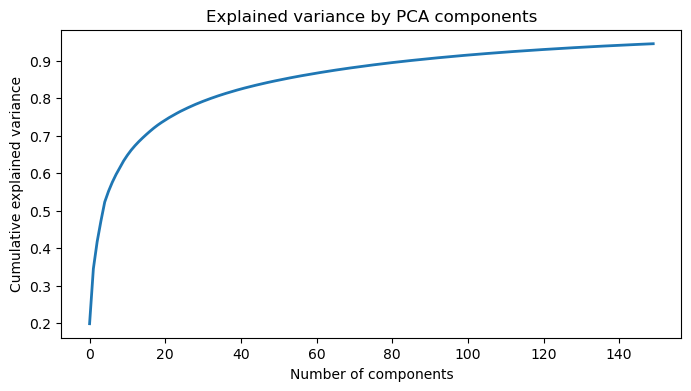

In [93]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.plot(explained_variance, lw=2)
plt.title('Explained variance by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

**8.5** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly


<img src="images/mean_face.jpg" width=200, height=200>


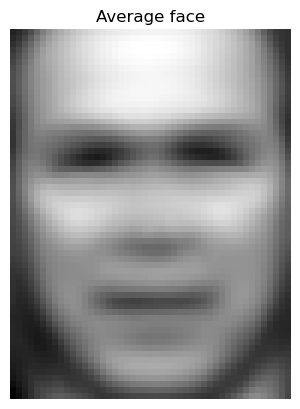

In [94]:
average_face = pca.mean_.reshape(h, w)

# Plot the average face
plt.imshow(average_face, cmap='gray')
plt.title('Average face')
plt.axis('off') # Hide the axes
plt.show()

**8.6** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

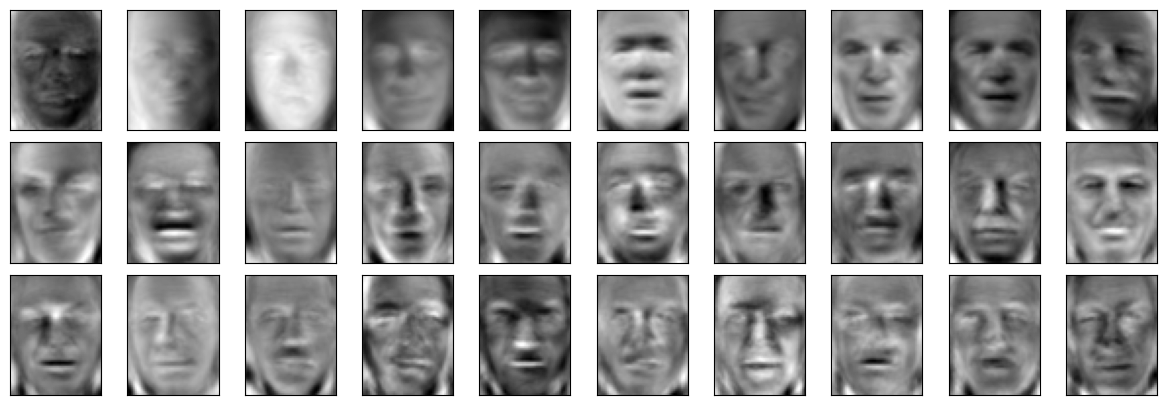

In [95]:
# Select the first 30 eigenfaces
eigenfaces = pca.components_[:30]

# Plot the first 30 eigenfaces
fig, axes = plt.subplots(3, 10, figsize=(15, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i].reshape(h, w), cmap='gray')

plt.show()

**8.7** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="images/eigenfaces_image.PNG" width=300, height=300>

Example of output: 

<img src="images/recomposition_example.jpg" width=600, height=600>

In [96]:
# Project the training data
X_train_pca = pca.transform(X_train)

# Project the testing data
X_test_pca = pca.transform(X_test)

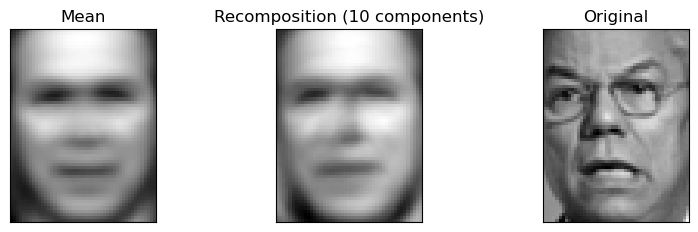

In [97]:
image_to_recompose = X_test[0]

# Project the sample to the PCA space
image_pca = pca.transform(image_to_recompose.reshape(1, -1))

# Recompose the image using the first 10 PCA components
# Start with the mean face
recomposed_image = pca.mean_.copy()

# Add the contributions of the first 10 principal components
for i in range(10):
    recomposed_image += pca.components_[i] * image_pca[0, i]

# Reshape the data to its original dimensions if it was flattened
recomposed_image = recomposed_image.reshape(h, w)

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(10, 2.5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.3, wspace=0.1))
axes[0].imshow(pca.mean_.reshape(h, w), cmap='gray')
axes[0].set_title('Mean')
axes[1].imshow(recomposed_image, cmap='gray')
axes[1].set_title('Recomposition (10 components)')
axes[2].imshow(image_to_recompose.reshape(h, w), cmap='gray')
axes[2].set_title('Original')
plt.show()

## Train a classifier

**8.8** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [98]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Assuming 'X_train_pca' and 'y_train' are your training features and labels respectively
# and 'X_test_pca' and 'y_test' are your testing features and labels respectively

# Initialize the AdaBoost classifier
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
ada_clf.fit(X_train_pca, y_train)

# Predict the labels of the test set
y_pred = ada_clf.predict(X_test_pca)

# Calculate the accuracy of the test set
accuracy = accuracy_score(y_test, y_pred)

# Alternatively, use the score method of the AdaBoost model to evaluate the test set directly
test_score = ada_clf.score(X_test_pca, y_test)

print(f"Accuracy of AdaBoost classifier on test set: {accuracy}")
print(f"Test score using the AdaBoost score method: {test_score}")

Accuracy of AdaBoost classifier on test set: 0.6140350877192983
Test score using the AdaBoost score method: 0.6140350877192983


**8.9** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [100]:
from sklearn.metrics import classification_report

# Assuming 'y_test' is the true labels for the test set and 'y_pred' is the predictions from the AdaBoost classifier

# Generate the classification report
report = classification_report(y_test, y_pred, digits=2)

print(report)

              precision    recall  f1-score   support

           0       0.58      0.59      0.59        78
           1       0.68      0.39      0.50        38
           2       0.65      0.78      0.71       159
           3       0.60      0.20      0.30        30
           4       0.46      0.51      0.49        37

    accuracy                           0.61       342
   macro avg       0.60      0.50      0.52       342
weighted avg       0.61      0.61      0.60       342



## Recognize a new face example using the learned model

**8.10** Try your model using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="images/prediction.png" width=300 height = 300>

In [107]:
# Define the original AdaBoost model
ada_clf_original = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train it on the original training data
ada_clf_original.fit(X_train, y_train)

# Now you can use ada_clf_original to predict
y_pred_original = ada_clf_original.predict(X_test)

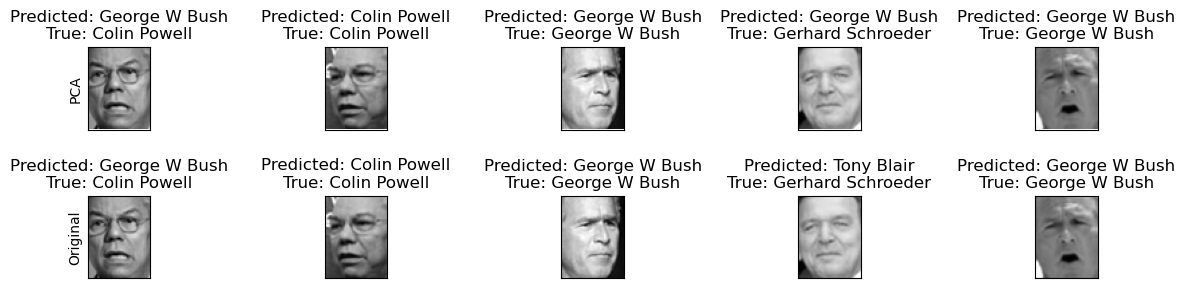

In [110]:
# Predict the labels on the PCA-transformed test data
y_pred_pca = ada_clf.predict(X_test_pca)

# You will need the original AdaBoost model trained on the non-PCA-transformed data for comparison
# Let's call it 'ada_clf_original', and it should have been trained on the original data

# Predict the labels on the original test data
y_pred_original = ada_clf_original.predict(X_test)

# Now let's plot some faces with the predictions
# Select a subset of faces to plot, for example, the first 5 faces
num_faces = 5

# Plotting the faces with predictions from PCA-transformed data
fig, axes = plt.subplots(2, num_faces, figsize=(15, 3),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.8, wspace=0.1))
for i in range(num_faces):
    axes[0, i].imshow(X_test[i].reshape(h, w), cmap='gray')
    axes[0, i].set_title(f'Predicted: {target_names[y_pred_pca[i]]}\nTrue: {target_names[y_test[i]]}')
    axes[1, i].imshow(X_test[i].reshape(h, w), cmap='gray')
    axes[1, i].set_title(f'Predicted: {target_names[y_pred_original[i]]}\nTrue: {target_names[y_test[i]]}')

axes[0, 0].set_ylabel('PCA')
axes[1, 0].set_ylabel('Original')
plt.show()

# Appendix

In case the library for exercise 1 does not work for you, here is the function that will create the filters for you:

In [ ]:
"""
Functions needed to create the Leung-Malik (LM) filter bank
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F